## Import libraries

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn,optim
from torch.utils.data import TensorDataset,DataLoader
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score

## Download Dataset

In [2]:
training_set = datasets.MNIST('/content',train=True,download=True)
testing_set = datasets.MNIST('/content',train=False,download=True)

## Prepare the data

In [29]:
invert = lambda image : 255 - image # function to invert the image
normalize = lambda image : image / 255 # function for bringing pixel values in range [0,1]

# function to prepare the dataset for a given digit
def prepare_training_data(dataset,digit):
    dataset_images = dataset.data.numpy() # convert the dataset into numpy array
    dataset_labels = dataset.targets.numpy() # convert the labels into numpy array
    
    indices = np.asarray(np.where(dataset_labels == digit)) # indices of occurrence of digit as label
    indices = indices.flatten()
    num_of_examples = len(indices) # total number of examples of this digit
    dataset_images_positive = dataset_images[indices] # images consisting of positive class
    # positive class has all labels as 1s
    dataset_labels_positive = np.full(shape=(num_of_examples,2),fill_value=[1,0],dtype=np.int64)
    dataset_images_negative = invert(dataset_images_positive) # images consisting of negative class
    # negative class has all labels as 0s
    dataset_labels_negative = np.full(shape=(num_of_examples,2),fill_value=[0,1],dtype=np.int64) 

    modified_dataset_images = np.concatenate((dataset_images_positive,dataset_images_negative))
    modified_dataset_labels = np.concatenate((dataset_labels_positive,dataset_labels_negative))
    tensor_x = torch.Tensor(modified_dataset_images)
    tensor_y = torch.Tensor(modified_dataset_labels)
    new_dataset = TensorDataset(tensor_x,tensor_y)
    return new_dataset

def prepare_testing_data(dataset,digit):
    dataset_images = dataset.data.numpy() # convert the dataset into numpy array
    dataset_labels = dataset.targets.numpy() # convert the labels into numpy array
    total = dataset_images.shape[0]
    indices = np.asarray(np.where(dataset_labels == digit)) # indices of occurrence of digit as label
    indices = indices.flatten()
    num_of_examples = len(indices) # total number of examples of this digit
    dataset_images_positive = dataset_images[indices] # images consisting of positive class
    # positive class has all labels as 1s
    dataset_labels_positive = np.full(shape=(num_of_examples,2),fill_value=[1,0],dtype=np.int64)
    dataset_images_negative = np.delete(dataset_images,indices,0) # images consisting of negative class
    # negative class has all labels as 0s
    dataset_labels_negative = np.full(shape=(total - num_of_examples,2),fill_value=[0,1],dtype=np.int64) 

    modified_dataset_images = np.concatenate((dataset_images_positive,dataset_images_negative))
    modified_dataset_labels = np.concatenate((dataset_labels_positive,dataset_labels_negative))
    tensor_x = torch.Tensor(modified_dataset_images)
    tensor_y = torch.Tensor(modified_dataset_labels)
    new_dataset = TensorDataset(tensor_x,tensor_y)
    return new_dataset

train_digit_set = prepare_training_data(training_set,0) # fetch the training set for a digit
test_digit_set = prepare_testing_data(testing_set,0) # fetch the test set for a digit
train_loader = DataLoader(train_digit_set,batch_size=64,shuffle=True)
test_loader = DataLoader(test_digit_set,batch_size=64,shuffle=True)

### Plotting some data

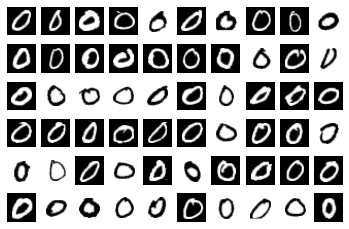

In [42]:
dataiter = iter(train_loader)
images,labels = dataiter.next()
figure = plt.figure()
# print(labels)
num_of_images = 60
for index in range(1,num_of_images+1):
    plt.subplot(6,10,index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(),cmap='gray_r')

## Build the neural network

In [45]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28,1000),
            nn.ReLU(),
            nn.Linear(1000,2),
            nn.Softmax(dim=1)
        )
        
    def forward(self,x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

criterion = nn.CrossEntropyLoss()
print(model)
optimizer = optim.SGD(model.parameters(),lr = 0.003,momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    for images,labels in train_loader:
        images = images.view(images.shape[0],-1) # flatten the image
        optimizer.zero_grad() # training pass
        output = model(images)
        loss = criterion(output,labels)
        loss.backward() # backpropagation
        optimizer.step() # optimizes its weights here
        
print(f"\nTraining time in minutes = {(time()-time0)/60}")

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=2, bias=True)
    (3): Softmax(dim=1)
  )
)

Training time in minutes = 0.3809292753537496


## Testing

In [46]:
correct_outputs = 0
total_outputs = 0
y_pred = [] # predicted labels
y_true = [] # true labels
for images,labels in train_loader:
    for i in range(len(labels)):
        img = images[i].view(1,784)
        with torch.no_grad():
            output = model(img)
        pred_list = output.numpy()[0]
        pred_label = np.argmax(pred_list)
#         print(output.numpy()[0])
        print(str(pred_list) + " " + str(labels.numpy()[i]))
#         true_label = np.argmax(labels.numpy()[i])
        if pred_label == true_label:
            correct_outputs += 1
        total_outputs += 1
    
# print(f"\nCorrect outputs : {correct_outputs} Total outputs : {total_outputs}")
# print(f"\nModel Accuracy : {accuracy_score(y_true,y_pred)}")
# print(f"\nModel Precision : {precision_score(y_true,y_pred)}")
# print(f"\nModel Recall : {recall_score(y_true,y_pred)}")
# print(f"\nModel F1 score : {f1_score(y_true,y_pred)}")

[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] 

[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] 

[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] 

[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] 

[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] 

[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] 

[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] 

[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] 

[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] 

[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] 

[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] 

[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] 

[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] 

[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] 

[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] 

[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] 

[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] 

[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] 

[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [0. 1.]
[1. 0.] [1. 0.]
[1. 0.] [0. 1.]
[1. 0.] 

In [58]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
cross_entropy_loss = nn.CrossEntropyLoss()
output = cross_entropy_loss(input, target)
output.backward()
print('input: ', input)
print('target: ', target)
print('output: ', output)

input:  tensor([[ 0.6856,  1.3626, -0.5891,  0.0470,  1.0072],
        [-0.2639,  0.9341, -0.9281,  0.7387,  1.7534],
        [ 0.6443, -0.4056, -0.4611, -0.7386,  0.4097]], requires_grad=True)
target:  tensor([2, 4, 2])
output:  tensor(1.9058, grad_fn=<NllLossBackward0>)
